# 1. Featrue Engineering

In [132]:
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
import re
import pandas_profiling
import joblib
import time
import sys
import lightgbm as lgb
import xgboost as xgb 
import catboost as cab
import my_functions as my
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import make_scorer,accuracy_score,confusion_matrix, mean_squared_error,roc_auc_score ,mean_absolute_error # 评估标准
sns.set_style("ticks") # dark/white/darkgrid/whitegrid

## 1.1 Data Pre-Processing

In [51]:
 # 5折交叉验证
def kvalid(train_x,bc_y_train,k=5):
    kf = KFold(n_splits=k, random_state=42)  # sklearn的交叉验证模块，用于划分数据
    MAE=[]
     # 交叉验证划分此时的训练集和验证集
    for train, test in kf.split(train_x):
        kf_X_tr = train_x.iloc[train]  # 训练集集
        kf_y_tr = bc_y_train[train]    # 训练集标签值
        kf_X_val =train_x.iloc[test]  # 验证集
        kf_y_val = bc_y_train[test]    # 验证集标签值
        clf = lgb.LGBMRegressor(objective='regression',metric= 'mae',silent=1,num_leaves=80,learning_rate=0.03, n_estimators=300)
        clf.fit(kf_X_tr,kf_y_tr,categorical_feature=cat_feat,verbose=0) 
        result=clf.predict(kf_X_val)
        MAE.append(mean_absolute_error(bcback(kf_y_val,maxlog),bcback(result,maxlog)))
    return {"MAE":round(np.mean(MAE),2)}

In [3]:
train=my.reduce_mem_usage(pd.read_csv("used_car_train_20200313.csv",sep=" "))
test=my.reduce_mem_usage(pd.read_csv("used_car_testB_20200421.csv",sep=" "))

Memory usage of dataframe is 37200128.00 MB
Memory usage after optimization is: 10200232.00 MB
Decreased by 72.6%
Memory usage of dataframe is 12000128.00 MB
Memory usage after optimization is: 3200232.00 MB
Decreased by 73.3%


### 1.1.1 Dirty data

In [4]:
data=pd.concat([train,test])
data=data.replace("-",np.nan)

In [5]:
data.drop(["offerType","seller"],axis=1,inplace=True)

### 1.1.2 Missing value

* 删除缺失率>=0.6的特征

In [6]:
my.Nullrate(data)

,0,nullrate,nullrate%
price,50000,0.250000,25.00
notRepairedDamage,32393,0.161965,16.20
fuelType,11604,0.058020,5.80
gearbox,7949,0.039745,3.97
bodyType,6010,0.030050,3.00
model,1,0.000005,0.00


* 不处理（树模型能自动处理缺失值）

* 插值补全：
    * 包括均值/中位数/众数/建模预测（k近邻/随机森林/lgb等）/多重插补/压缩感知补全/矩阵补全等；
    * 根据其它强相关特征对该特征进行数据分箱,然后选择该特征所在分箱的相应特征的均值或中位数,来填充缺失值；
    * 高级填充方法可参考fancyimpute库。fancyimpute主要提供以下几种填充方式： KNN、 NuclearNormMinimization、SoftImpute、IterativeImputer、BiScaler

In [8]:
mls=my.Nullrate(data).index.tolist()
mls.remove("price")
for i in mls:
    data[i].fillna(data[i].mode()[0],inplace=True)

### 1.1.3 Outlier

In [9]:
data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6',
       'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14'],
      dtype='object')

In [10]:
label="price"
ID_feat=['SaleID']
date_feat=['regDate','creatDate']
cat_feat=[ 'name',  'model', 'brand', 'bodyType', 'fuelType','gearbox', 'notRepairedDamage', 'regionCode']
num_feat=[i for i in data.columns if i not in cat_feat+[label]+date_feat+ID_feat]

In [11]:
data[num_feat].describe(percentiles=[0.05,0.25,0.5,0.75,0.95])

,power,kilometer,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,200000.000000,200000.0,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,119.429150,NaN,NaN,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
std,184.885438,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,0.000000,0.5,30.453125,-4.296875,-4.468750,-7.273438,-4.363281,0.000000,0.000000,0.000000,0.000000,0.000000,-9.171875,-5.664062,-9.640625,-4.156250,-6.546875
5%,0.000000,4.0,41.000000,-3.314453,-1.781250,-3.173828,-1.693359,0.227051,0.000000,0.007236,0.013634,0.009583,-5.656250,-3.378906,-3.787109,-1.927734,-2.119141
25%,75.000000,12.5,43.125000,-3.193359,-0.969727,-1.460938,-0.921387,0.243530,0.000038,0.062469,0.035339,0.033905,-3.708984,-1.954102,-1.870117,-1.055664,-0.437988
50%,110.000000,15.0,44.593750,-3.052734,-0.383301,0.103363,-0.074219,0.257812,0.000809,0.095886,0.056976,0.058563,1.625977,-0.362305,-0.133423,-0.036270,0.140259
75%,150.000000,15.0,46.000000,3.996094,0.240997,1.565430,0.869263,0.265381,0.101929,0.125366,0.079407,0.087524,2.844238,1.256836,1.776367,0.942871,0.681641
95%,232.000000,15.0,47.750000,5.152344,1.227588,3.341797,2.107422,0.277832,0.119568,0.168213,0.108765,0.125000,4.054883,2.841797,4.097656,2.187500,1.364258
max,19312.000000,15.0,52.312500,7.320312,19.031250,9.851562,6.828125,0.291748,0.153442,1.411133,0.160767,0.222778,12.359375,18.812500,13.851562,11.148438,8.656250


power极差很大，最大值达到19312，根据赛题，power最大为600，因此将>600的记录全部化为600

In [12]:
data.loc[data.power>600,"power"]=600

In [13]:
#基于IQR进行过滤
def IQRFilter(df,colnames,cut=3): 
    """
    df:需要过滤的dataframe
    colnames：需要过滤的列名
    cut：基于IQR的过滤截断点
    """
    # 下四分位数值、中位数，上四分位数值
    for col in colnames:
        Q1, median, Q3 = np.percentile(df[col].values, (25, 50, 75), interpolation='midpoint')
        # 四分位距
        IQR = Q3 - Q1
        # 内限
        inner = [Q1-1.5*IQR, Q3+1.5*IQR]
        # 外限
        outer = [Q1-cut*IQR, Q3+cut*IQR] 
        # 过滤极端异常值
        df=df[(df[col].values<outer[1]) & (df[col].values>outer[0]) ]
    return df

In [14]:
data=pd.concat([IQRFilter(data[data.SaleID<200000],num_feat),data[data.SaleID>=200000]]) #对训练集进行异常删减，然后重新concat

### 1.1.4 Label

使用Box-Cox变换族一般可以保证将数据进行成功的正态变化，但在二分变量或较少水平的等级变量的情况下，不能成功进行转换，此时可以考虑使用广义线性模型，例如logistic模型、johson转换等。

In [15]:
train_y=data[data.SaleID<200000][label]

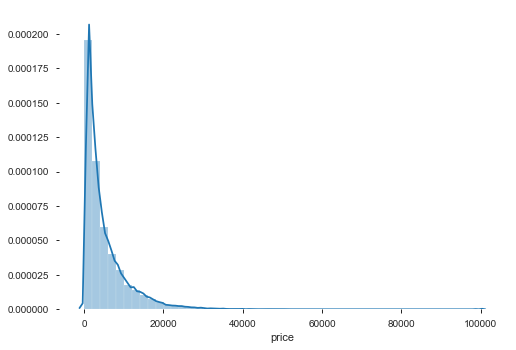

In [16]:
sns.distplot(train_y)

从标签分布可以看出不服从正态分布，采用box-cox使其正态化。

In [17]:
bc_y_train, maxlog= stats.boxcox(train_y) #bc_y 是box-cox后的数据，lamda是变换参数

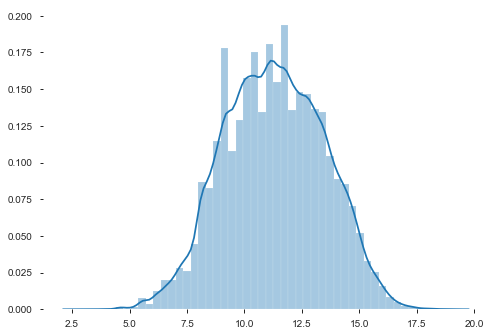

In [18]:
sns.distplot(bc_y_train)

In [19]:
def bcback(bc_y,maxlog): #将变换后的数值进行还原
    return np.power((bc_y*maxlog+1),1/maxlog)

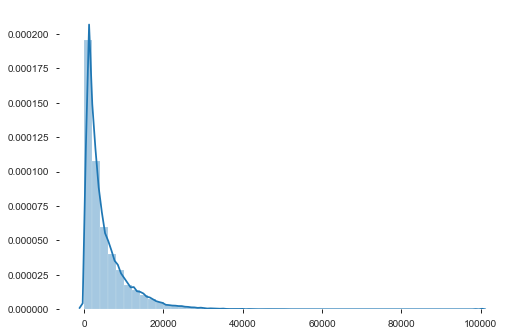

In [20]:
sns.distplot(bcback(bc_y_train,maxlog))

### 1.1.5 Cat_feature encoding

类别特征进行标签化,化为从0开始的int数值

In [21]:
data

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235718,0.101990,0.129517,0.022812,0.097473,-2.880859,2.804688,-2.419922,0.795410,0.914551
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264893,0.121033,0.135742,0.026596,0.020584,-4.902344,2.095703,-1.030273,-1.722656,0.245483
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251465,0.114929,0.165161,0.062164,0.027069,-4.847656,1.803711,1.565430,-0.832520,-0.229980
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274414,0.110291,0.121948,0.033386,0.000000,-4.507812,1.286133,-0.501953,-2.437500,-0.478760
5,5,137642,20090602,24.0,10,0.0,1.0,0.0,109,10.0,...,0.260254,0.000518,0.119812,0.090942,0.048767,1.885742,-2.722656,2.457031,-0.286865,0.206543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,249995,111443,20041005,4.0,4,0.0,0.0,1.0,150,15.0,...,0.263672,0.000292,0.141846,0.076416,0.039276,2.072266,-2.531250,1.716797,-1.063477,0.326660
49996,249996,152834,20130409,65.0,1,0.0,0.0,0.0,179,4.0,...,0.255371,0.000991,0.155884,0.108398,0.067871,1.358398,-3.291016,4.269531,0.140503,0.556152
49997,249997,132531,20041211,4.0,4,0.0,0.0,1.0,147,12.5,...,0.262939,0.000318,0.141846,0.071960,0.042969,2.166016,-2.417969,1.371094,-1.073242,0.270508
49998,249998,143405,20020702,40.0,1,4.0,0.0,1.0,176,15.0,...,0.282227,0.000023,0.067505,0.067505,0.009003,2.029297,-2.939453,0.568848,-1.717773,0.316406


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181137 entries, 0 to 49999
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   SaleID             181137 non-null  int32   
 1   name               181137 non-null  int32   
 2   regDate            181137 non-null  int32   
 3   model              181137 non-null  float16 
 4   brand              181137 non-null  int8    
 5   bodyType           181137 non-null  float16 
 6   fuelType           181137 non-null  float16 
 7   gearbox            181137 non-null  float16 
 8   power              181137 non-null  int16   
 9   kilometer          181137 non-null  float16 
 10  notRepairedDamage  181137 non-null  category
 11  regionCode         181137 non-null  int16   
 12  creatDate          181137 non-null  int32   
 13  price              131137 non-null  float64 
 14  v_0                181137 non-null  float16 
 15  v_1                181137 non-null 

In [23]:
my.Nullrate(data[cat_feat])

,0,nullrate,nullrate%


In [24]:
for i in cat_feat:
    data[i]=data[i].apply(lambda x: int(float(x)))

In [25]:
data.notRepairedDamage=data.notRepairedDamage.astype("int")

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181137 entries, 0 to 49999
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SaleID             181137 non-null  int32  
 1   name               181137 non-null  int64  
 2   regDate            181137 non-null  int32  
 3   model              181137 non-null  int64  
 4   brand              181137 non-null  int64  
 5   bodyType           181137 non-null  int64  
 6   fuelType           181137 non-null  int64  
 7   gearbox            181137 non-null  int64  
 8   power              181137 non-null  int16  
 9   kilometer          181137 non-null  float16
 10  notRepairedDamage  181137 non-null  int32  
 11  regionCode         181137 non-null  int64  
 12  creatDate          181137 non-null  int32  
 13  price              131137 non-null  float64
 14  v_0                181137 non-null  float16
 15  v_1                181137 non-null  float16
 16  v_2

## 1.2 Feature Construction

* 特征构造
    * 单一特征
        * 数值特征（归一化/标准化/分箱离散化/box-cox变换）
        * 类别特征（py库：category_encoders）
            * 时间序列-年月日/是否假期/周末/rank/count
            * 地理信息-背后有没有什么实际含义进行提取/len/rank
            * 高基数特征（id）-count/rank/CatBoost Encoder/LeaveOneOut、 WeightOfEvidence、 James-Stein、M-estimator
            * 稀疏特征-OneHot, Hashing, LeaveOneOut,target encoding
    * 特征组合
        * 数值+数值 （多项式组合/gplearn库）
        * 类别+数值 （statistic特征）
* 标签分析
    * 标签分布：是否均匀；是否异常（正态分布？）
    * 标签box-cox转化

In [27]:
#由于数据没有标准化，因此先采用树模型如LGB进行特征选择。
def lgb_feat_selection(df,label,k=5):
    train_x=df[df.SaleID<200000].drop(label,axis=1)
    train_y=df[df.SaleID<200000][label]
    clf = lgb.LGBMRegressor(objective='regression',metric= 'mae',silent=1,num_leaves=80,learning_rate=0.03, n_estimators=300)
    clf.fit(train_x, train_y,categorical_feature=cat_feat,verbose=0) 
    keys=df.columns
    values=clf.feature_importances_
    feim=dict(zip(keys,values))
    rank=sorted(feim.items(),  key=lambda d: d[1], reverse=True) #按得分降序
    derank=sorted(feim.items(),  key=lambda d: d[1], reverse=False) #按得分升序
    rank_keys=[i[0] for i in rank][0:k]
    derank_keys=[i[0] for i in derank][0:k]
    lgb.plot_importance(clf)
    return {"Kbest":rank_keys,"kworst":derank_keys}

{'Kbest': ['v_9',
  'regDate',
  'regionCode',
  'model',
  'power',
  'v_5',
  'name',
  'v_2',
  'v_0',
  'price'],
 'kworst': ['gearbox',
  'fuelType',
  'bodyType',
  'brand',
  'v_3',
  'SaleID',
  'v_6',
  'creatDate',
  'v_12',
  'notRepairedDamage']}

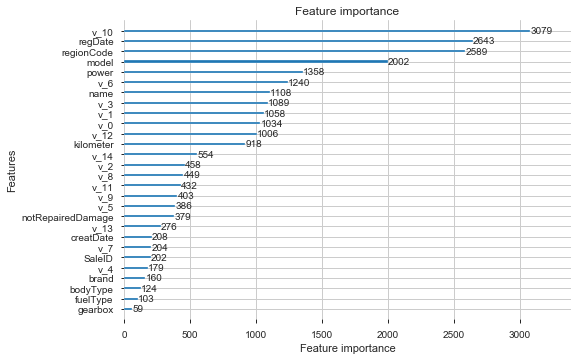

In [28]:
lgb_feat_selection(data,label,k=10)

In [29]:
cat_item=['regDate','regionCode','model',"name"]

In [30]:
num_item=['power','kilometer','v_2','v_0','v_9','v_5']

* Time series

相对时间和绝对时间，节假日，双休日等,赛题中creatDate和regDate是时间序列特征；regDate - 汽车注册时间；creatDate - 卖车广告发布时间，因此可利用二者时间差推断汽车使用时间

In [31]:
#刊登卖车广告时间晚于注册时间，时间差可利用建立使用时间特征
data["used_time"]=(pd.to_datetime(data.creatDate,format='%Y%m%d', errors='coerce')-pd.to_datetime(data.regDate,format='%Y%m%d', errors='coerce')).dt.days #强制进行转换，不满足转换要求，则设为缺失值

In [32]:
my.Nullrate(data)

,0,nullrate,nullrate%
price,50000,0.276034,27.6
used_time,11951,0.065978,6.6


In [33]:
data[data.used_time.isnull()][["creatDate","regDate"]].head().append(data[data.used_time.isnull()][["creatDate","regDate"]].tail())

,creatDate,regDate
20,20160311,19970004
22,20160326,19970008
42,20160328,19960009
51,20160325,20020006
69,20160325,19990007
49916,20160324,20150008
49925,20160316,20020003
49935,20160307,19960007
49938,20160319,20080004
49939,20160316,19950006


used_time的缺失值是由于regDate数据异常引起，月份不能是0；因此提取两个时间的年份信息，再转化为天数作为填充。

In [34]:
data.loc[(data.used_time.isnull()),"used_time"] = (data.loc[(data.used_time.isnull()),"creatDate"].apply(lambda x:eval(str(x)[0:4]))-
                                                data.loc[(data.used_time.isnull()),"regDate"].apply(lambda x:eval(str(x)[0:4])))*365

广告发布时间以及注册时间如果是节假日可能也会影响价格，因此创建一个节假日特征。

In [35]:
# """
# from chinese_calendar import is_workday, is_holiday,is_in_lieu  #判断日期是否工作日；节假日；调休
# #由于时间序列数据是德国的日历；因此不能用中国日历来创建特征。
# creat_time=pd.to_datetime(data.creatDate,format='%Y%m%d', errors='coerce')
# data["is_workday_creat"]=creat_time.apply(lambda x:is_workday(x) )
# data["is_holiday_creat"]=creat_time.apply(lambda x:is_holiday(x) )
# data["is_in_lieu_creat"]=creat_time.apply(lambda x:is_in_lieu(x) )
#由于chinese_calendar只支持2003-2020年日历查询，而regDate大多数是2004年之前的数据，因此不创建节假日特征。
# """

In [36]:
data["reg_time"]=data.regDate.apply(lambda x:eval(str(x)[0:6])) #抽取年份+月份信息;用于后续统计信息创建

In [37]:
creat_time=pd.to_datetime(data.creatDate,format='%Y%m%d', errors='coerce')
data["year_creat"]=creat_time.dt.year
data["month_creat"]=creat_time.dt.month
data["week_creat"]=creat_time.dt.weekday

In [38]:
data["year_reg"]=creat_time.dt.year
data["month_reg"]=creat_time.dt.month
data["week_reg"]=creat_time.dt.weekday

In [39]:
def used_time_cut(x): #按照使用年限进行切割
    if x<=365:
        return 0
    elif x<=1095:
        return 1
    elif x<=2555:
        return 2
    else:
        return 3

In [40]:
data["used_time_cut"]=data.used_time.apply(lambda x:used_time_cut(x))

In [41]:
cat_feat=cat_feat+["reg_time","used_time_cut"]

In [52]:
kvalid(data[data.SaleID<200000].drop("price",axis=1),bc_y_train,k=10)

{'MAE': 558.27}

* location

经测试，location信息可能会造成信息泄露，故不采用该特征

### 1.2.1 Feature combination

* Base on experience

In [53]:
data["name_len"]=data["name"].apply(lambda x : len(str(x)))
data["kilo_perday"]=data["kilometer"]/data["used_time"]

In [54]:
data1=data.copy()

* Base on gplearn-with multiple non-linear functions

- gplearn 有目的地约束了符号回归问题。
- 手工特征工程中，我们会对两个或者多个特征进行一些加减乘除的操作，来生成一些特征，希望能够生成一些根据领域的先验知识。
- 对金额特征, 日期特征进行比值操作生成一些特征，这些特征经常能够提升验证集和测试集的分数，在模型中也有很高的重要程度。

In [55]:
def Gp_feat_gen(train_x,bc_y_train):
    from gplearn.genetic import SymbolicTransformer
    function_set = ['add', 'sub', 'mul', 'div',
                    'sqrt', 'log', 'abs', 'neg', 'inv',
                    'max', 'min']
    gp = SymbolicTransformer(generations=30, population_size=1800,
                             hall_of_fame=100, n_components=10,
                             function_set=function_set,
                             parsimony_coefficient=0.0005,
                             max_samples=0.9, verbose=0,
                             random_state=42, n_jobs=-1)
    gp.fit(train_x,bc_y_train)
    return pd.DataFrame(gp.transform(train_x))

In [56]:
# gp_feat=Gp_feat_gen(data[data.SaleID<200000].drop(label,axis=1),bc_y_train)

In [57]:
#效果不好

* Base on statistics

重要特征的计数、均值、标准差等统计值；
匿名特征的计数

In [58]:
def count_feat(df,cols): #统计自身的各值频数
    for col in cols:
        newF1 = df.groupby([col])[col].count().to_frame().rename(columns={col:col+'__count'})
        df = pd.merge(df, newF1, on=[col], how='left')
    return df

In [59]:
data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6',
       'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14',
       'used_time', 'reg_time', 'year_creat', 'month_creat', 'week_creat',
       'year_reg', 'month_reg', 'week_reg', 'used_time_cut', 'name_len',
       'kilo_perday'],
      dtype='object')

In [60]:
data=count_feat(data,cols=cat_item+num_item)

In [61]:
def stat_feat_label(df,onecatcols): #统计类别特征与标签的统计值 
    Train= df[df.SaleID<200000] #分离出训练集
    funcs=["max","min","mean","sum","median","std","skew"]
    for col in onecatcols:
        gb=Train.groupby(col)
        dfgb=gb[label].agg(funcs) 
        df=df.merge(dfgb,how="left",on=col)
        df.rename(columns={"max":col+"_"+label+"_"+"max","min":col+"_"+label+"_"+"min","mean":col+"_"+label+"_"+"mean",
                     "sum":col+"_"+label+"_"+"sum","median":col+"_"+label+"_"+"median","std":col+"_"+label+"_"+"std",
                     "skew":col+"_"+label+"_"+"skew"},inplace=True)
    return df

In [66]:
data=my.reduce_mem_usage(stat_feat_label(data,cat_feat))

Memory usage of dataframe is 153966450.00 MB
Memory usage after optimization is: 53616552.00 MB
Decreased by 65.2%


In [67]:
def stat_feat(df,onecatcols,onenumcols): #统计类别特征与标签的统计值
    for col in onecatcols:
        for j in onenumcols: 
            gb=df.groupby(col)
            funcs=["max","min","mean","sum","median","std","skew"]
            dfgb=gb[j].agg(funcs)
            df=df.merge(dfgb,how="left",on=col)
            df.rename(columns={"max":col+"_"+j+"_"+"max","min":col+"_"+j+"_"+"min","mean":col+"_"+j+"_"+"mean",
                         "sum":col+"_"+j+"_"+"sum","median":col+"_"+j+"_"+"median","std":col+"_"+j+"_"+"std",
                         "skew":col+"_"+j+"_"+"skew"},inplace=True)
    return df

In [71]:
df_stat=my.reduce_mem_usage(stat_feat(data,cat_item,num_item))

Memory usage of dataframe is 156864642.00 MB
Memory usage after optimization is: 117376776.00 MB
Decreased by 25.2%


加入的统计型特征变量有利于提高精度

### 1.2.2 Numeric feature

* Data binning

等频分箱；等距分箱；Best-KS 分箱（类似利用基尼指数进行二分类）；卡方分箱；聚类分箱。

* 分箱算法的好处等同于数据离散化的好处，大致有下面几点：
* 1.可以减少过拟合的风险，因为分箱相当于对于数据去粗粒度描述。
* 2.增加稀疏数据的概率，减少计算量，因为0的数据变多了。
* 3.减少噪声数据的影响，比如一组数据按照0~100均匀分布，当数据中突然出现一个10000的数据，如果不做分箱的化会对Logistic Regression这种模型的训练造成很大影响。
* 4.方便特征衍生，因为数据离散化后就可以把特征直接相互做内积提升特征维度。
* 5.离散化后可以提升模型的鲁棒性，比如我们有一组数据是年龄，比如A30岁、B50岁，到了第二年A变成31岁，B变成51岁，所有数据都变了理论上要更新模型。但是如果数据分箱了之后，比如分箱逻辑是小于40岁为0，大于40岁为1，则第一年和第二年数据没有变化，模型也不用变化。

In [ ]:
# #等距分箱
# le = LabelEncoder()
# for col in continuous_feature:
#     data[col+"_cut"]=le.fit_transform(pd.cut(data[col],bins=4).astype("category"))

In [72]:
# 聚类划分
from sklearn.cluster import KMeans
def KMeans_cut(df,col,k=5):
    kmeans = KMeans(n_clusters=k)  # 离散为 k 等份
    kmeans.fit_transform(df[col].values.reshape(-1, 1)) # 只取一个特征进行聚类离散化
    df[col+"_cut"]=kmeans.labels_
    return df

In [73]:
for i in num_item:
    data=KMeans_cut(data,i,k=5)

In [110]:
my.reduce_mem_usage(data).to_csv("data.csv",index=None)

Memory usage of dataframe is 63206720.00 MB
Memory usage after optimization is: 59946254.00 MB
Decreased by 5.2%


###  1.2.3 Categorical featrue

(when using xgb and not tree model)

In [75]:
import category_encoders as ce

* 无序离散特征:OneHot, Hashing, LeaveOneOut,target encoding 方法效果较好，但是使用OneHot时要避免高基类别的特征以及基于决策树的模型。
* 有序离散特征:尝试 Ordinal, Binary, OneHot, LeaveOneOut, and Target. 
* 高基数特征: LeaveOneOut、 WeightOfEvidence、 James-Stein、M-estimator 适合用来处理高基数特征。
* 回归问题:Target 与 LeaveOneOut 方法可能不会有比较好的效果。
* Helmert、 Sum、 Backward Difference、 Polynomial 在机器学习问题里的效果往往不是很好(过拟合的原因)
* Helmert, Sum, BackwardDifference and Polynomial 基本没啥用，但是当你有确切的原因或者对于业务的理解的话，可以进行尝试。

* label encoding
特征存在内在顺序 (ordinal feature)
* one hot encoding
特征无内在顺序，category数量 < 4
* target encoding (mean encoding, likelihood encoding, impact encoding)
特征无内在顺序，category数量 > 4
* beta target encoding
特征无内在顺序，category数量 > 4, K-fold cross validation
* 不做处理（模型自动编码）
CatBoost，lightgbm

In [76]:
data_xgb=data.copy()

In [77]:
data_cate_nuiq=data[cat_feat].nunique().to_frame()
data_cate_nuiq.columns=["nunique"]
data_cate_nuiq.sort_values(by="nunique",ascending=False)

,nunique
name,116164
regionCode,7975
reg_time,325
model,248
brand,40
bodyType,8
fuelType,7
used_time_cut,4
gearbox,2
notRepairedDamage,2


In [78]:
high_cat=data_cate_nuiq[data_cate_nuiq["nunique"]>=10].index.tolist() #CatBoost/LeaveOneOut/rank/count
low_cat=data_cate_nuiq[data_cate_nuiq["nunique"]<10].index.tolist() # CatBoost/onehot/target encoding/

In [79]:
high_cat

['name', 'model', 'brand', 'regionCode', 'reg_time']

In [80]:
low_cat

['bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'used_time_cut']

* low_cate with onehot

In [81]:
ohe=ce.one_hot.OneHotEncoder(verbose=0, cols=low_cat, drop_invariant=True, return_df=True, handle_missing='value', handle_unknown='value', use_cat_names=True)

In [82]:
df_ohe=ohe.fit_transform(data[low_cat+["SaleID"]])

In [83]:
data_xgb=pd.merge(data_xgb,df_ohe,how="left",on="SaleID")

In [84]:
data_xgb.drop(low_cat,axis=1,inplace=True)

In [85]:
data_xgb.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'power', 'kilometer',
       'regionCode', 'creatDate', 'price',
       ...
       'fuelType_5.0', 'fuelType_6.0', 'gearbox_0.0', 'gearbox_1.0',
       'notRepairedDamage_0.0', 'notRepairedDamage_1.0', 'used_time_cut_3.0',
       'used_time_cut_2.0', 'used_time_cut_1.0', 'used_time_cut_0.0'],
      dtype='object', length=144)

* high_cate with target encoding/m_estimate

In [86]:
#target_encoder
tge=ce.target_encoder.TargetEncoder(verbose=0, cols=high_cat, drop_invariant=True, 
                                               return_df=True, handle_missing='value', handle_unknown='value',
                                               min_samples_leaf=1, smoothing=1.0)
X_train=data[data.SaleID<200000].drop("price",axis=1)
y_train=data.loc[data.SaleID<200000,"price"]
df_tge=tge.fit(X_train,y_train).transform(data.drop("price",axis=1))
df_tge_onlyhighcate=df_tge[high_cat+["SaleID"]]
df_tge_onlyhighcate.columns=[str(i)+"_tge" for i in high_cat+["SaleID"]]

In [87]:
df_tge_onlyhighcate[df_tge_onlyhighcate.SaleID_tge>=200000].shape

(50000, 6)

In [88]:
data_xgb=pd.merge(data_xgb,df_tge_onlyhighcate,how="left",left_on="SaleID",right_on="SaleID_tge")

In [92]:
data_xgb.drop(high_cat+["SaleID_tge"],axis=1,inplace=True)

In [111]:
my.reduce_mem_usage(data_xgb).to_csv("data_xgb.csv",index=None)

Memory usage of dataframe is 95278062.00 MB
Memory usage after optimization is: 57782703.00 MB
Decreased by 39.4%


## 1.3 Feature Selection

* 过滤式（filter）：先对数据进行特征选择，然后在训练学习器，常见的方法有 Relief/方差选择法/相关系数法/卡方检验法/互信息法；
* 包裹式（wrapper）：直接把最终将要使用的学习器的性能作为特征子集的评价准则，常见方法有 LVM（Las Vegas Wrapper） ；
* 嵌入式（embedding）：结合过滤式和包裹式，学习器训练过程中自动进行了特征选择，常见的有 lasso 回归；
* 降维:PCA/ LDA/ ICA.

feature_selector可以滤除以下特征：
* 具有高missing-values百分比的特征
* 具有单个值的特征（即数据集中该特征取值的集合只有一个元素）(方差为0)
* 具有高相关性的特征
* 对模型预测结果无贡献的特征（即zero importance）
* 对模型预测结果只有很小贡献的特征（即low importance）

### 1.3.1 pytools: feature_selector

In [96]:
from feature_selector import FeatureSelector

In [97]:
fs = FeatureSelector(data =data[data.SaleID<200000].drop("price",axis=1), labels = data.loc[data.SaleID<200000,"price"])

In [99]:
fs_xgb=FeatureSelector(data_xgb[data_xgb.SaleID<200000].drop("price",axis=1), labels = data_xgb.loc[data_xgb.SaleID<200000,"price"])

* 综合使用全部方法

In [100]:
fs.identify_all(selection_params = {'missing_threshold': 0.5, 
 'correlation_threshold': 0.98, 
 'task': 'regression', 
 'eval_metric': 'mae', 
 'cumulative_importance': 0.99})
train_removed = fs.remove(methods = 'all')
train_removed_all = fs.remove(methods = 'all', keep_one_hot=False) #返回的df中不包含onehot特征
feat_saved=train_removed.columns.tolist()

2 features with greater than 0.50 missing values.

1 features with a single unique value.

31 features with a correlation magnitude greater than 0.98.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 363.553	valid_0's l2: 760779
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[816]	valid_0's l1: 357.368	valid_0's l2: 738687
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 365.094	valid_0's l2: 736951
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 356.759	valid_0's l2: 744932
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 363.429	valid_0's l2: 736341
Training until validation sc

In [101]:
fs_xgb.identify_all(selection_params = {'missing_threshold': 0.5, 
 'correlation_threshold': 0.98, 
 'task': 'regression', 
 'eval_metric': 'mae', 
 'cumulative_importance': 0.99})
train_removed_xgb = fs_xgb.remove(methods = 'all')
train_removed_all_xgb = fs_xgb.remove(methods = 'all', keep_one_hot=False) #返回的df中不包含onehot特征
feat_saved_xgb=train_removed_xgb.columns.tolist()

2 features with greater than 0.50 missing values.

1 features with a single unique value.

39 features with a correlation magnitude greater than 0.98.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 363.552	valid_0's l2: 719002
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 369.282	valid_0's l2: 878491
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 372.227	valid_0's l2: 788135
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's l1: 356.579	valid_0's l2: 663678
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 363.343	valid_0's l2: 712594
Training until 

In [ ]:
feat_saved_xgb

In [106]:
data_sel=data[[label]+feat_saved]

In [107]:
data_xgb_sel=data_xgb[[label]+feat_saved_xgb]

In [112]:
my.reduce_mem_usage(data_sel).to_csv("data_sel.csv",index=None)

Memory usage of dataframe is 37304129.00 MB
Memory usage after optimization is: 36760718.00 MB
Decreased by 1.5%


In [113]:
my.reduce_mem_usage(data_xgb_sel).to_csv("data_xgb_sel.csv",index=None)

Memory usage of dataframe is 37133085.00 MB
Memory usage after optimization is: 32423523.00 MB
Decreased by 12.7%


* 高missing-values百分比的特征

In [ ]:
fs.identify_missing(missing_threshold = 0.5) #查看缺失值
fs.missing_stats.head()

In [ ]:
missing_features = fs.ops['missing']

In [ ]:
missing_features

In [ ]:
fs.plot_missing()

* 单个唯一值特征

In [ ]:
fs.identify_single_unique()

In [ ]:
single_unique_features=fs.ops['single_unique']

In [ ]:
single_unique_features

In [ ]:
fs.plot_unique()

* 共线性特征

In [ ]:
fs.identify_collinear(correlation_threshold = 0.99)

In [ ]:
fs.plot_collinear()

In [ ]:
# list of collinear features to remove
collinear_features = fs.ops['collinear']

In [ ]:
collinear_features[:5]

In [ ]:
# dataframe of collinear features
fs.record_collinear.head()

* 零重要度特征

In [ ]:
# Pass in the appropriate parameters
fs.identify_zero_importance(task = 'regression', 
 eval_metric = 'mae', 
 n_iterations = 10, 
 early_stopping = True)

In [ ]:
# list of zero importance features
zero_importance_features = fs.ops['zero_importance']

In [ ]:
len(zero_importance_features )

In [ ]:
fs.feature_importances.head(10).append(fs.feature_importances.tail(10))

In [ ]:
# plot the feature importances
fs.plot_feature_importances(threshold = 0.995, plot_n = 12)

In [ ]:
one_hot_features = fs.one_hot_features
base_features = fs.base_features
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))

* 低重要度特征

In [ ]:
fs.identify_low_importance(cumulative_importance = 0.995)

In [ ]:
low_importance_features = fs.ops['low_importance']

In [ ]:
len(low_importance_features)

* 需要移除的特征

In [ ]:
drop_feature=list(set(low_importance_features+zero_importance_features+collinear_features+single_unique_features+missing_features))

In [ ]:
len(drop_feature)

In [ ]:
data_sel=data_all.drop(drop_feature,axis=1)

In [ ]:
lgb_cv_valid(data_sel)

In [ ]:
data_sel.to_csv("data_sel.csv")

* 移除指定特征

In [ ]:
train_no_missing_zero = fs.remove(methods = ['missing', 'zero_importance'])

In [ ]:
feature_saved=train_removed.columns.tolist() 

In [ ]:
data[feature_saved].info()

In [ ]:
#查看特征选择后的mae
lgb_cv_valid(pd.concat([data[feature_saved],data["price"]],axis=1))

### 1.3.2 Lasso

In [ ]:
def Lasso_feat_drop(train_x,bc_y_train,alpha=0.05): #套索回归，矩阵稀疏，将不重要的特征权重系数设为0
    from sklearn.linear_model import Lasso #L1范数正则化
    X_train, X_test, y_train, y_test = train_test_split(train_x,bc_y_train, test_size=0.66, random_state=42)
    Lasso= Lasso(alpha=alpha)
    Lasso.fit(X_train,y_train)
    keys=train_x.columns
    values=Lasso.coef_
    importance=dict(zip(keys,values))
    return [k for k, v in importance.items() if v ==0]

In [ ]:
data_lasso=data_all.copy()
ls=data_all.columns.tolist()
ls.remove("price")
for i in ls:
    data_lasso[i].fillna(data_lasso[i].mode()[0],inplace=True)

In [ ]:
data_lasso.loc[data_lasso.SaleID<200000,"price"].isnull().sum()

In [ ]:
from sklearn.linear_model import Lasso #L1范数正则化
Lasso= Lasso(alpha=0.3)
Lasso.fit(data_lasso[data_lasso.SaleID<200000].drop("price",axis=1),data_lasso.loc[data_lasso.SaleID<200000,"price"])

In [ ]:
lgb_cv_valid(df.drop(feat_lasso_drop,axis=1)) #误差增大，不能滤除这些参数

# 2. Model

## 2.1 Model-LGBM

* Params tuning

In [184]:
data=pd.read_csv("data.csv")
X_train=data[data.SaleID<200000].drop("price",axis=1)
bc_y_train, maxlog= stats.boxcox(data[data.SaleID<200000]["price"]) #bc_y 是box-cox后的数据，lamda是变换参数
y_train=bc_y_train

In [139]:
#使用Hyperopt调参
from hyperopt import fmin, tpe, hp,Trials,STATUS_OK
def f_lgb(params):
    clf = lgb.LGBMRegressor(**params)
    kf = KFold(n_splits=5, random_state=42)  # sklearn的交叉验证模块，用于划分数据
    MAE=[]
     # 交叉验证划分此时的训练集和验证集
    train_x=X_train
    for train, test in kf.split(train_x):
        kf_X_tr = train_x.iloc[train]  # 训练集集
        kf_y_tr = bc_y_train[train]    # 训练集标签值
        kf_X_val =train_x.iloc[test]  # 验证集
        kf_y_val = bc_y_train[test]    # 验证集标签值
        clf = lgb.LGBMRegressor(objective='regression',metric= 'mae',silent=1,num_leaves=80,learning_rate=0.03, n_estimators=300)
        clf.fit(kf_X_tr,kf_y_tr,categorical_feature=cat_feat,verbose=0) 
        result=clf.predict(kf_X_val)
        MAE.append(mean_absolute_error(bcback(kf_y_val,maxlog),bcback(result,maxlog)))
    return {'loss': round(np.mean(MAE),2), 'status': STATUS_OK}

# hp.normal，hp.lognormal，hp.quniform
space_lgb = {
        "objective":'regression_l1',
        "eval_metric":"mae",
        "n_estimators":100,
        'num_leaves': hp.choice('num_leaves', range(20,130)),
        "learning_rate":hp.uniform("learning_rate",0.01,0.1),
        "reg_alpha":hp.uniform("reg_alpha",0,0.05),
        "reg_lambda":hp.uniform("reg_lambda",0,0.05)}
trials = Trials()
best1 = fmin(f_lgb, space_lgb, algo=tpe.suggest, max_evals=5, trials=trials)

100%|█████████████████████████████████████████████████████████████| 5/5 [16:20<00:00, 196.15s/trial, best loss: 385.36]


In [140]:
best1 

{'learning_rate': 0.07922079045340327,
 'num_leaves': 26,
 'reg_alpha': 0.012492997412838236,
 'reg_lambda': 0.025742522365766837}

In [ ]:
fig, ax = plt.subplots(1)#, figsize=(10,10))
xs = [t['misc']['vals']['num_leaves'] for t in trials.trials]
ys = [-t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20)
# ax.set_title('Iris Dataset - KNN', fontsize=18)
ax.set_xlabel('num_leaves', fontsize=12)
ax.set_ylabel('cross validation mae', fontsize=12)

* result

In [142]:
clf = lgb.LGBMRegressor(**best1)
clf.fit(X_train, bc_y_train,categorical_feature=cat_feat,verbose=0) 

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.07922079045340327,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=26,
              objective=None, random_state=None, reg_alpha=0.012492997412838236,
              reg_lambda=0.025742522365766837, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [143]:
test_x=data[data.SaleID>=200000].drop(label,axis=1)
predict=clf.predict(test_x)

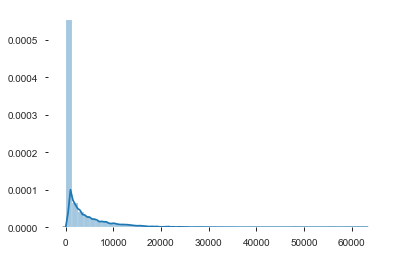

In [144]:
sns.distplot(bcback(predict,maxlog))

In [145]:
result_lgb=pd.DataFrame()
result_lgb["SaleID"]=range(150000,200000)
result_lgb["price"]=bcback(predict,maxlog)

In [146]:
result_lgb["price"].describe()

count    50000.000000
mean      2107.124008
std       4182.227546
min         39.100829
25%        122.136307
50%        186.690342
75%       2121.491647
max      62813.532771
Name: price, dtype: float64

In [147]:
result_lgb.to_csv("result_lgb.csv",index=None)

## 2.2 Model-CATBOOST

* Params tuning

In [148]:
def f_cab(params):
    clf = cab.CatBoostRegressor(**params)
    kf = KFold(n_splits=5, random_state=42)  # sklearn的交叉验证模块，用于划分数据
    MAE=[]
     # 交叉验证划分此时的训练集和验证集
    train_x=X_train
    for train, test in kf.split(train_x):
        kf_X_tr = train_x.iloc[train]  # 训练集集
        kf_y_tr = bc_y_train[train]    # 训练集标签值
        kf_X_val =train_x.iloc[test]  # 验证集
        kf_y_val = bc_y_train[test]    # 验证集标签值
        clf = lgb.LGBMRegressor(objective='regression',metric= 'mae',silent=1,num_leaves=80,learning_rate=0.03, n_estimators=300)
        clf.fit(kf_X_tr,kf_y_tr,categorical_feature=cat_feat,verbose=0) 
        result=clf.predict(kf_X_val)
        MAE.append(mean_absolute_error(bcback(kf_y_val,maxlog),bcback(result,maxlog)))
    return {'loss': round(np.mean(MAE),2), 'status': STATUS_OK}

# hp.normal，hp.lognormal，hp.quniform
space_cab = {
        "loss_function":'MAE',
        "verbose":0,
        "n_estimators":100,
        'depth': hp.choice('depth', range(4,15)),
        "learning_rate":hp.uniform("learning_rate",0.01,0.1),
        "l2_leaf_reg":hp.uniform("l2_leaf_reg",0,0.05)}
trials=Trials()
best_cab = fmin(f_cab, space_cab, algo=tpe.suggest, max_evals=2, trials=trials)

100%|███████████████████████████████████████████████| 2/2 [58:19<00:00, 1749.51s/trial, best loss: 0.22414662417918302]


In [155]:
best_cab ={'learning_rate': 0.06678548500225957, 'depth': 10, 'l2_leaf_reg': 0.011592262655679031,"loss_function":'MAE', "verbose":0,}

* result

In [151]:
cat_feat

['name',
 'model',
 'brand',
 'bodyType',
 'fuelType',
 'gearbox',
 'notRepairedDamage',
 'regionCode',
 'reg_time',
 'used_time_cut']

In [152]:
cat_feat_index=[data.columns.tolist().index(i) for i in cat_feat]

In [157]:
clf = cab.CatBoostRegressor(**best_cab )
clf.fit(X_train, bc_y_train,cat_features=cat_feat_index,verbose=0)

In [158]:
test_x=data[data.SaleID>=200000].drop(label,axis=1)
predict=clf.predict(test_x)

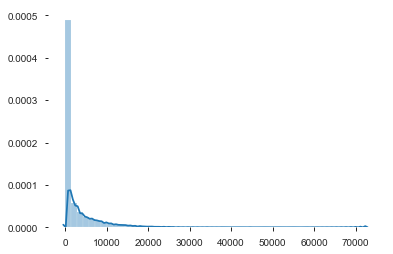

In [159]:
sns.distplot(bcback(predict,maxlog))

In [160]:
result_cab=pd.DataFrame()
result_cab["SaleID"]=range(150000,200000)
result_cab["price"]=bcback(predict,maxlog)

In [161]:
result_cab["price"].describe()

count    50000.000000
mean      2212.614232
std       4059.055011
min         37.505177
25%        227.531552
50%        492.054132
75%       2151.080121
max      72394.819162
Name: price, dtype: float64

In [162]:
result_cab.to_csv("result_cab.csv",index=None)

## 2.2 Model-XGBOOST

* Params tuning

In [179]:
data=pd.read_csv("data_xgb.csv")
X_train=data[data.SaleID<200000].drop("price",axis=1)
bc_y_train, maxlog= stats.boxcox(data[data.SaleID<200000]["price"]) #bc_y 是box-cox后的数据，lamda是变换参数
y_train=bc_y_train

In [165]:
def f_xgb(params):
    clf = xgb.XGBRegressor(**params)
    kf = KFold(n_splits=5, random_state=42)  # sklearn的交叉验证模块，用于划分数据
    MAE=[]
     # 交叉验证划分此时的训练集和验证集
    train_x=X_train
    for train, test in kf.split(train_x):
        kf_X_tr = train_x.iloc[train]  # 训练集集
        kf_y_tr = bc_y_train[train]    # 训练集标签值
        kf_X_val =train_x.iloc[test]  # 验证集
        kf_y_val = bc_y_train[test]    # 验证集标签值
        clf = lgb.LGBMRegressor(objective='regression',metric= 'mae',silent=1,num_leaves=80,learning_rate=0.03, n_estimators=300)
        clf.fit(kf_X_tr,kf_y_tr,verbose=0) 
        result=clf.predict(kf_X_val)
        MAE.append(mean_absolute_error(bcback(kf_y_val,maxlog),bcback(result,maxlog)))
    return {'loss': round(np.mean(MAE),2), 'status': STATUS_OK}

# hp.normal，hp.lognormal，hp.quniform
space_xgb = {
        "objective":'reg:squarederror',
        "eval_metric":"mae",
        'max_depth': hp.choice('max_depth', range(2,15)),
        "learning_rate":hp.uniform("learning_rate",0.01,0.1),
        "reg_alpha":hp.uniform("reg_alpha",0,0.05),
        "reg_lambda":hp.uniform("reg_lambda",0,0.05)}
trials=Trials()
best_xgb = fmin(f_xgb, space_xgb, algo=tpe.suggest, max_evals=2, trials=trials)

100%|█████████████████████████████████████████████████████████████| 2/2 [05:35<00:00, 167.87s/trial, best loss: 370.83]


* result

In [170]:
best_xgb

{'learning_rate': 0.06865186354555616,
 'max_depth': 7,
 'reg_alpha': 0.00780928407267999,
 'reg_lambda': 0.021773428713610057}

In [185]:
clf = xgb.XGBRegressor(**best_xgb,objective='reg:squarederror')
clf.fit(X_train, bc_y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.06865186354555616,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0,
             reg_alpha=0.00780928407267999, reg_lambda=0.021773428713610057,
             scale_pos_weight=1, seed=None, silent=None, subsample=1,
             verbosity=1)

In [187]:
predict=clf.predict(test_x)

In [188]:
predict

array([], shape=(50000, 0), dtype=float32)

In [ ]:
result_xgb=pd.DataFrame()
result_xgb["SaleID"]=range(150000,200000)
result_xgb["price"]=bcback(predict,maxlog)

In [ ]:
result_xgb["price"].describe()

In [ ]:
result_xgb.to_csv("result_xgb.csv",index=None)

In [ ]:
pasle

## 3. Model Ensemble

## 3.1 Bagging

In [193]:
weight=[0.3,0.3,0.4]
y_pred_lgb=pd.read_csv("result_lgb.csv").price
y_pred_cab=pd.read_csv("result_cab.csv").price
y_pred_cnn=pd.read_csv("results_cnn.csv").price

In [194]:
y_pred_weight=weight[0]*pd.Series(y_pred_lgb)+weight[1]*pd.Series(y_pred_cab)+weight[2]*pd.Series(y_pred_cnn)

In [195]:
y_pred_weight

0         571.375393
1         814.235221
2        4047.983903
3        1183.835313
4         939.369828
            ...     
49995    2856.212595
49996    8684.901791
49997    2444.352394
49998    2077.224272
49999    2290.910907
Name: price, Length: 50000, dtype: float64

In [197]:
results=pd.DataFrame()
results["SaleID"]=range(150000,200000)
results["price"]=y_pred_weight

In [198]:
results["price"].describe()

count    50000.000000
mean      3650.684632
std       4454.304926
min         40.335827
25%        828.363632
50%       2014.978772
75%       4705.280192
max      54905.175980
Name: price, dtype: float64

In [200]:
results.to_csv("result_bagging.csv",index=None)

mlgb,mxgb,mcab的权重分别设为0.3，0.5，0.2

In [ ]:
 # 采用5折交叉验证
def kvalid(X,k=5):
    kf = KFold(n_splits=k, random_state=42)  # sklearn的交叉验证模块，用于划分数据
    MAE=[]
    MAE_lgb=[]
    MAE_xgb=[]
    MAE_cab=[]
     # 交叉验证划分此时的训练集和验证集
    for train, test in kf.split(X_train): 
        kf_X_val = X_train.reset_index(drop=True).iloc[test]  # 验证集
        kf_y_val = y_train.reset_index(drop=True).iloc[test]    # 验证集标签值
        MAE.append(mean_absolute_error(kf_y_val,weight_ensemble(kf_X_val,[0.3,0.5,0.2])))
        MAE_lgb.append(mean_absolute_error(kf_y_val,mlgb.predict(kf_X_val)))
        MAE_xgb.append(mean_absolute_error(kf_y_val,mxgb.predict(kf_X_val)))
        MAE_cab.append(mean_absolute_error(kf_y_val,mcab.predict(kf_X_val)))
    return {"MAE_ensemble":round(np.mean(MAE),2),"MAE_lgb":round(np.mean(MAE_lgb),2),
            "MAE_xgb":round(np.mean(MAE_xgb),2),"MAE_cab":round(np.mean(MAE_cab),2)}

In [ ]:
kvalid(X_train,k=10)

In [ ]:
y_pred_lgb_bc=box_cox_back(weight_ensemble(X_test,[0.3,0.5,0.2]),maxlog)

In [ ]:
sns.distplot(y_pred_lgb_bc)

In [ ]:
pd.Series(y_pred_lgb_bc).describe()

In [ ]:
kvalid_bc(X_train,k=10)

## 3.2 Stacking

In [189]:
from mlxtend.regressor import StackingRegressor
from mlxtend.data import boston_housing_data
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [190]:
#初始化模型
lr = LinearRegression()
ridge = Ridge(random_state=1)
Lasso = Lasso(random_state=1)
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')
rf=RandomForestRegressor()

In [191]:
mlgb = lgb.LGBMRegressor(**best1)
mlgb.fit(X_train, bc_y_train,categorical_feature=cat_feat,verbose=0) 
mcab = cab.CatBoostRegressor(**best_cab )
mcab.fit(X_train, bc_y_train,cat_features=cat_feat_index,verbose=0)

In [ ]:
X_tr=pd.concat([
    pd.Series(mlgb.predict(X_train)),
    pd.Series(mcab.predict(X_train)),
    pd.Series(mcab.predict(X_train))],
    axis=1).values
X_ts=pd.concat([
    pd.Series(mlgb.predict(X_test)),
    pd.Series(mxgb.predict(X_test)),
    pd.Series(mcab.predict(X_test))],axis=1).values
ridge.fit(X_tr,y_train)
Stacking_result = ridge.predict(X_ts)

In [ ]:
def Stacking(X_train,bc_y_train,X_test):
    svr_rbf = SVR(kernel='rbf')

    

    return Stacking_result

In [ ]:
 # 采用5折交叉验证
def kvalid_stacking(X_train,y_train,X_test,k=5):
    kf = KFold(n_splits=k, random_state=42)  # sklearn的交叉验证模块，用于划分数据
    MAE=[]
     # 交叉验证划分此时的训练集和验证集
    for train, test in kf.split(X_train):
        kf_X_tr = X_train.reset_index(drop=True).iloc[train]  # 训练集集
        kf_y_tr = y_train.reset_index(drop=True).iloc[train]    # 训练集标签值
        kf_X_val = X_train.reset_index(drop=True).iloc[test]  # 验证集
        kf_y_val = y_train.reset_index(drop=True).iloc[test]    # 验证集标签值
        MAE.append(mean_absolute_error(kf_y_val,Stacking(kf_X_tr,kf_y_tr,kf_X_val)))
    return {"MAE_stacking":round(np.mean(MAE),2)}